In [1]:
%matplotlib inline
import os
import sys
import gc
import time
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pygame
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from commons.configuration_manager import ConfigurationManager
from src.learning.training.collector import Collector
from src.learning.training.training_file_reader import TrainingFileReader
from src.utilities.transformer import Transformer
from notebooks.notebook_commons import read_stored_data_with_labels, read_stored_data_with_shifted_labels, create_memorized_dataset

window_width = 500
window_height = 200

black = (0, 0, 0)
white = (255, 255, 255)
red = (255, 0, 0)
green = (0, 153, 0)
blue = (0, 128, 255)

pygame.init()
font = pygame.font.SysFont('Roboto', 20)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def plot_stuff(title, plot_elems, figsize=(18, 10)):
    fig=plt.figure(figsize=figsize)
    plt.title(title)
    #plt.ylabel('dunno')
    plt.xlabel('Count')
    
    for plot_elem in plot_elems:
        plt.plot(plot_elem['data'], label=plot_elem['label'], alpha=plot_elem['alpha'])

    plt.grid(axis='y')
    plt.legend(loc='best')
    plt.show()
        
def get_mem_dataset_with_full_video(filename, length, interval):
    mem_frames_np, mem_telemetry_np, mem_diffs_np = create_memorized_dataset(*read_stored_data_with_labels(reader, transformer, filename, collector.steering_columns(), collector.diff_steering_columns()), length, interval)
    view_frames_np = reader.read_video(filename + '.avi')[((length - 1) * interval):]
    
    assert view_frames_np.shape[0] == mem_frames_np.shape[0], "Frames length mismatch!"
    assert mem_frames_np.shape[0] == mem_telemetry_np.shape[0] == mem_diffs_np.shape[0], "Mem lengths differ!"
    return mem_frames_np, mem_telemetry_np, mem_diffs_np, view_frames_np

def get_shifted_mem_dataset_with_full_video(filename, length, interval):
    mem_frames_np, mem_telemetry_np, mem_diffs_np = create_memorized_dataset(*read_stored_data_with_shifted_labels(reader, transformer.cut_wide_and_normalize_video_shifted, filename, collector.steering_column(), collector.steering_column()), length, interval)
    view_frames_np = reader.read_video(filename + '.avi')[((length - 1) * interval):-1]
    
    assert view_frames_np.shape[0] == mem_frames_np.shape[0], "Frames length mismatch!"
    assert mem_frames_np.shape[0] == mem_telemetry_np.shape[0] == mem_diffs_np.shape[0], "Mem lengths differ!"
    return mem_frames_np, mem_telemetry_np, mem_diffs_np, view_frames_np

def validate_partial(memory, i):
    memory_string = 'n{}_m{}'.format(*memory)
    path = '../../training/' + memory_string + '/'

    mem_frame = np.load(path + GenFiles.frame.format(memory_string, i)) * 255
    return mem_frame.astype(np.uint8)[:,:,:3]

In [3]:
config_manager = ConfigurationManager()
config = config_manager.config

reader = TrainingFileReader(path_to_training='../../training/validation_laps/')
collector = Collector()

validation_laps = ['validation_lap_1_2020_02_10', '2020_02_23_i1', 'bad_lap_1_2020_02_10', 'bad_lap_2_2020_02_17']
memory_variants = [(1, 1), (4, 1), (4, 4), (8, 1), (8, 4), (12, 1)]
memory = memory_variants[0]

transformer = Transformer(config, memory_tuple=memory)

mem_frames, mem_telems, mem_diffs, display_frames = get_shifted_mem_dataset_with_full_video(validation_laps[1], *memory)
print(mem_frames.shape)
print(mem_telems.shape)

(2533, 60, 180, 3)
(2533, 1)


In [4]:
from tensorflow.keras.models import load_model
multi = load_model('../../training/models/model_n{}_m{}_6.h5'.format(*memory))

In [ ]:
from PIL import Image

frame = mem_frames[25][:,:,:3]
Image.fromarray((frame * 255).astype(np.uint8)).show()

In [5]:
pred_steer = []
actual_steer = []

pygame.display.init()
pygame.display.set_caption("Prediction viewer")
screen = pygame.display.set_mode((window_width, window_height))

try:
    pred_smoothing = []
    for i in range(0, display_frames.shape[0]):
        frame = display_frames[i]
        screen.fill(black)
        
        converted_telem = mem_telems[i][np.newaxis, :]
        converted_frame = mem_frames[i].astype(np.float32)[np.newaxis, :]
        
        # gear, steering, throttle, braking
        predictions = multi.predict([converted_frame, converted_telem])[0]
        #predictions = multi.predict(converted_frame)[0]
        predicted_steering = predictions[0]
        
        pred_steering_str = "P: {0:.4f}".format(predicted_steering)
        if predicted_steering >= 0.0:
            prediction_text = font.render(pred_steering_str, True, green)
        else:
            prediction_text = font.render(pred_steering_str, True, blue)
        
        actual_steering = mem_telems[i, 0]
        actual_steering_str = "T: {0:.4f}".format(actual_steering)
        if actual_steering >= 0.0:
            actual_text = font.render(actual_steering_str, True, green)
        else:
            actual_text = font.render(actual_steering_str, True, blue)
        
        pred_steer.append(predicted_steering)
        actual_steer.append(actual_steering)
        
        delta = actual_steering - predicted_steering
        delta_str = "D: {0:.4f}".format(delta)
        delta_text = font.render(delta_str, True, white)
        
        #frame = mem_frames[i][:,:,:3]
        #frame = validate_partial(memory, i)
        frame = np.rot90(frame)
        surface = pygame.surfarray.make_surface(frame)
        
        x = (window_width - frame.shape[0]) // 2
        y = 0
        
        #time.sleep(0.05)
        screen.blit(prediction_text, (200, window_height - 75))
        screen.blit(actual_text, (200, window_height - 45))
        screen.blit(delta_text, (200, window_height - 15))
        screen.blit(surface, (x, y))
        pygame.display.update()

        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    sys.exit(0)
    pygame.display.quit()
except (KeyboardInterrupt, SystemExit, Exception) as ex:
    print(ex)
    pygame.display.quit()

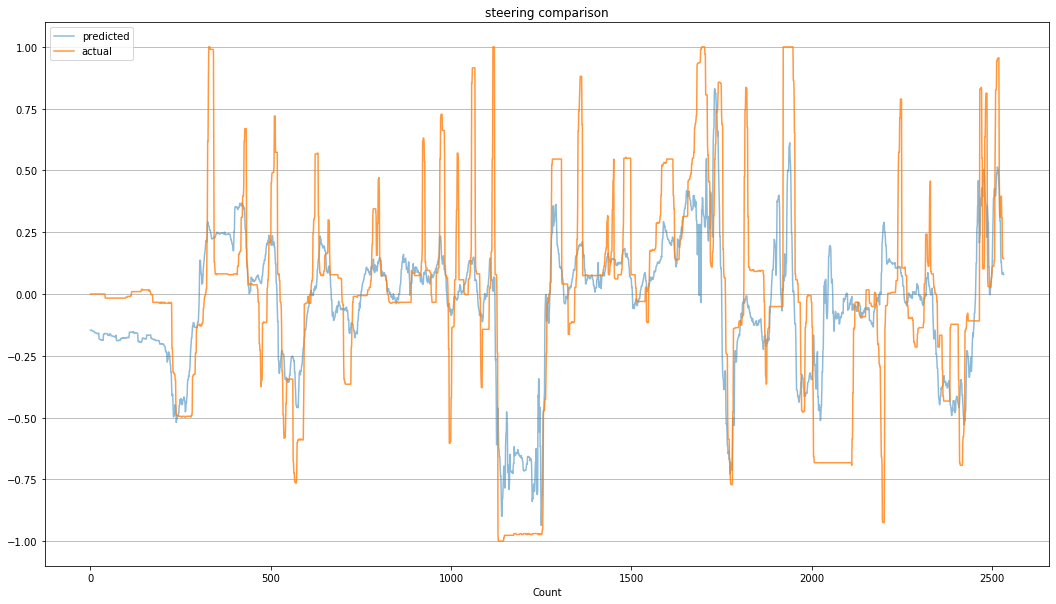

In [6]:
plotto = []
plotto.append({'data': pred_steer, 'label': 'predicted', 'alpha': 0.5})
plotto.append({'data': actual_steer, 'label': 'actual', 'alpha': 0.8})

plot_stuff('steering comparison', plotto)

In [1]:
drive_data = reader.read_specific_telemetry_columns('2020_02_23_i1.csv', ['d_steering', 'p_steering'])

plotto = []
plotto.append({'data': drive_data[['d_steering']].to_numpy()[0], 'label': 'predicted', 'alpha': 0.5})
plotto.append({'data': drive_data[['p_steering']].to_numpy()[0], 'label': 'actual', 'alpha': 0.8})

plot_stuff('steering comparison', plotto)

NameError: name 'reader' is not defined